In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from ultralytics import YOLO
import matplotlib.pyplot as plt
import torch

In [2]:
yolo_model = YOLO("yolov8m.pt")

In [3]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Preprocess the data (e.g., normalize pixel values)
x_train = x_train / 255.0
x_test = x_test / 255.0

# Define the model architecture
mnist_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

# Compile the model
mnist_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
mnist_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 [==============================] - 1s 666us/step - loss: 0.2599 - accuracy: 0.9252 - val_loss: 0.1379 - val_accuracy: 0.9592
Epoch 2/10
1875/1875 [==============================] - 1s 639us/step - loss: 0.1143 - accuracy: 0.9663 - val_loss: 0.0976 - val_accuracy: 0.9704
Epoch 3/10
1875/1875 [==============================] - 1s 618us/step - loss: 0.0773 - accuracy: 0.9761 - val_loss: 0.0888 - val_accuracy: 0.9729
Epoch 4/10
1875/1875 [==============================] - 1s 616us/step - loss: 0.0573 - accuracy: 0.9824 - val_loss: 0.0769 - val_accuracy: 0.9768
Epoch 5/10
1875/1875 [==============================] - 1s 609us/step - loss: 0.0435 - accuracy: 0.9862 - val_loss: 0.0744 - val_accuracy: 0.9786
Epoch 6/10
1875/1875 [==============================] - 1s 603us/step - loss: 0.0345 - accuracy: 0.9897 - val_loss: 0.0799 - val_accuracy: 0.9753
Epoch 7/10
1875/1875 [==============================] - 1s 598us/step - loss: 0.0270 - accuracy: 0.9919 - val_loss: 0.0707 -

In [38]:
def detect_and_classify_digits(image_path):
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    # Perform object detection using YOLO
    results = yolo_model.predict(image)
    results = results[0]
    
    print(results)
    
    # Extract bounding box coordinates, scores, and classes
    boxes = results.boxes.xyxy.cpu().numpy()
    classes = results.boxes.cls.cpu().numpy()
    scores = results.boxes.conf.cpu().numpy()
    
    print("boxes",boxes)
    print("classes",classes)
    print("scores",scores)
    
    # Iterate over the detected objects
    for box, score, obj_class in zip(boxes, scores, classes):
        if score > 0.5:  # Threshold for confidence score
            xmin, ymin, xmax, ymax = box * np.array([width, height, width, height])
            
            # Ensure the bounding box coordinates are within the image dimensions
            xmin = max(0, int(xmin))
            ymin = max(0, int(ymin))
            xmax = min(width, int(xmax))
            ymax = min(height, int(ymax))
            
            # Extract the digit region of interest (ROI)
            digit_roi = image[ymin:ymax, xmin:xmax]

            if digit_roi.size == 0:
                continue  # Skip empty or invalid digit ROIs

            digit_roi = cv2.cvtColor(digit_roi, cv2.COLOR_BGR2GRAY)

            # Pre-process the digit ROI for digit recognition
            digit_roi = cv2.resize(digit_roi, (28, 28))
            digit_roi = digit_roi / 255.0
            digit_roi = np.expand_dims(np.expand_dims(digit_roi, axis=-1), axis=0)

            # Perform digit recognition using MNIST model
            digit_prediction = mnist_model.predict(digit_roi)
            digit_label = np.argmax(digit_prediction)

            # Draw bounding box and label on the original image
            cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 2)
            cv2.putText(image, str(digit_label), (int(xmin), int(ymin) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Display the image with bounding boxes and digit labels
    plt.imshow(image[:, :, ::-1])
    plt.axis('off')
    plt.show()


0: 448x640 1 remote, 259.4ms
Speed: 5.7ms preprocess, 259.4ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'c

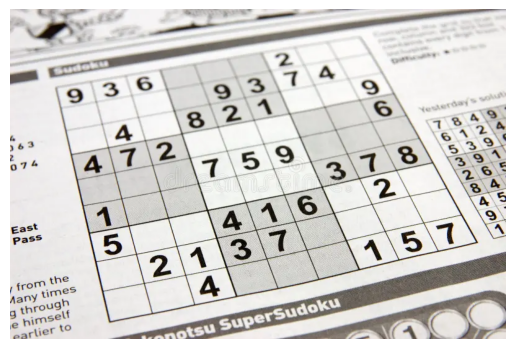

In [39]:
image_path = "images/sudoku2.jpg"
detect_and_classify_digits(image_path)

In [6]:
cv2.imshow('Digits Recognition', cv2.imread(image_path))

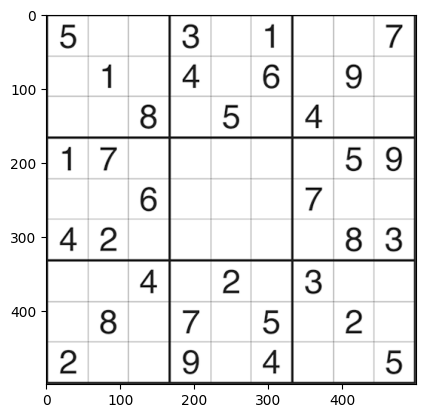

In [7]:
img = cv2.imread(image_path)
img2 = img[:,:,::-1]
plt.imshow(img)